In [57]:
# !pip install transformers datasets
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback, BertTokenizer, BertModel, BertForSequenceClassification
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [58]:
file_path = "Symptom2Disease.csv"
data = pd.read_csv(file_path)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,Unnamed: 0,label,text
0,21,Fibromyalgia,I’m experiencing widespread pain throughout my...
1,268,Malaria,"I've been experiencing severe itching, chills,..."
2,232,Arthritis,"Recently, my muscles have felt quite weak, and..."
3,44,Fungal infection,"I've had a lot of itching on my skin, which oc..."
4,105,Pneumonia,"I've been experiencing chills, feeling worn ou..."


In [59]:
symptoms = data['text']
diseases = data['label']

# Encode disease labels
label_encoder = LabelEncoder()
data['disease_encoded'] = label_encoder.fit_transform(diseases)
temp_texts, test_texts, temp_labels, test_labels = train_test_split(symptoms, data['disease_encoded'], test_size=0.2, random_state=42)
train_texts, val_texts, train_labels, val_labels = train_test_split(temp_texts, temp_labels, test_size=0.25, random_state=42)

In [77]:
data['disease_encoded']

,disease_encoded
0,12
1,18
2,3
3,13
4,22
...,...
1258,33
1259,32
1260,34
1261,18


In [60]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# tokenizer.pad_token = tokenizer.eos_token

train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=128)

In [61]:
train_dataset = Dataset.from_dict({'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask'], 'labels': list(train_labels)})
val_dataset = Dataset.from_dict({'input_ids': val_encodings['input_ids'], 'attention_mask': val_encodings['attention_mask'], 'labels': list(val_labels)})

In [62]:
# model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=len(label_encoder.classes_))
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

if model.config.pad_token_id is None:
    model.config.pad_token_id = tokenizer.eos_token_id

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [63]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
)

In [64]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
)

In [65]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,3.599100,3.502554
2,3.364400,3.287101
3,3.090000,3.024813
4,2.630500,2.539078
5,1.970000,1.901625
6,1.375600,1.255697
7,0.839700,0.738774
8,0.441400,0.467418
9,0.327600,0.390963
10,0.110900,0.261835


TrainOutput(global_step=480, training_loss=1.871833079556624, metrics={'train_runtime': 297.5193, 'train_samples_per_second': 25.444, 'train_steps_per_second': 1.613, 'total_flos': 303523398041760.0, 'train_loss': 1.871833079556624, 'epoch': 10.0})

In [66]:
results = trainer.evaluate()
print(results)

model.save_pretrained('./gpt2-disease-prediction')
tokenizer.save_pretrained('./gpt2-disease-prediction')

{'eval_loss': 0.2618352770805359, 'eval_runtime': 1.0899, 'eval_samples_per_second': 232.138, 'eval_steps_per_second': 3.67, 'epoch': 10.0}


('./gpt2-disease-prediction/tokenizer_config.json',
 './gpt2-disease-prediction/special_tokens_map.json',
 './gpt2-disease-prediction/vocab.txt',
 './gpt2-disease-prediction/added_tokens.json')

In [100]:
training_logs = trainer.state.log_history

train_losses = [log["loss"] for log in training_logs if "loss" in log]
eval_losses = [log["eval_loss"] for log in training_logs if "eval_loss" in log]

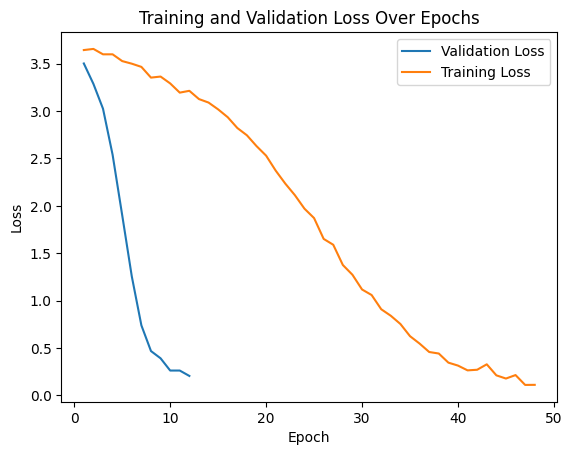

In [105]:
epochs1 = range(1, len(eval_losses) + 1)
epochs2 = range(1, len(train_losses) + 1)

import matplotlib.pyplot as plt
plt.plot(epochs1, eval_losses, label='Validation Loss')
plt.plot(epochs2, train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

Evaluation and testing

In [67]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
import numpy as np

test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=128)
test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': list(test_labels),
})

In [68]:
results = trainer.evaluate(eval_dataset=test_dataset)
print("Evaluation Results:", results)

Evaluation Results: {'eval_loss': 0.2049001008272171, 'eval_runtime': 1.0632, 'eval_samples_per_second': 237.956, 'eval_steps_per_second': 3.762, 'epoch': 10.0}


In [69]:
raw_predictions = trainer.predict(test_dataset)
predictions = np.argmax(raw_predictions.predictions, axis=1)
true_labels = test_labels

In [70]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
import numpy as np

accuracy = accuracy_score(true_labels, predictions)
print("Accuracy:", accuracy)

precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average="weighted")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

unique_labels = np.unique(np.concatenate((true_labels, predictions)))
class_report = classification_report(true_labels, predictions, labels=unique_labels, target_names=label_encoder.classes_[unique_labels] if label_encoder is not None else None)
print("Classification Report:\n", class_report)

Accuracy: 0.9525691699604744
Precision: 0.9380, Recall: 0.9526, F1-Score: 0.9422
Classification Report:
                                  precision    recall  f1-score   support

                           Acne       1.00      1.00      1.00         8
                      Arthritis       1.00      1.00      1.00        12
               Bronchial Asthma       1.00      1.00      1.00        11
                 Celiac Disease       1.00      1.00      1.00         1
           Cervical spondylosis       1.00      1.00      1.00         8
                    Chicken pox       0.78      0.88      0.82         8
       Chronic Fatigue Syndrome       0.00      0.00      0.00         2
                    Common Cold       1.00      1.00      1.00         8
                         Dengue       1.00      0.60      0.75        10
          Dimorphic Hemorrhoids       1.00      1.00      1.00         9
                   Fibromyalgia       0.00      0.00      0.00         0
               Fun

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

In [98]:
from transformers import TextClassificationPipeline

pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, top_k = 24)

def decode_label(label_dict):
    label_idx = int(label_dict.replace("LABEL_", ""))
    return label_encoder.inverse_transform([label_idx])[0]

pred1 = pipe("I have been experiencing a skin rash on my arms, legs, and torso for the past few weeks. It is red, itchy, and covered in dry, scaly patches")
pred2 = pipe("I have been feeling tired and experiencing muscle pain. I also noticed a slight fever and sore throat.")
pred3 = pipe("My skin has been itching intensely, and I've developed red patches that are dry and flaky on my arms and legs")
pred4 = pipe("Every time I eat dairy products, I feel bloated, gassy, and sometimes have diarrhea")
pred5 = pipe("Nothing is wrong. I'm feeling perfectly healthy and happy")
pred6 = pipe("HEAD PAIN TOO MUCH CAN'T WORK!!!! URGENT!!!!!!")
pred7 = pipe("zzz random text something something pain cough fever sore hello world")
pred8 = pipe("")

decoded_pred1 = {'disease': decode_label(pred1[0][0]['label']), 'score': pred1[0][0]['score']}
decoded_pred2 = {'disease': decode_label(pred2[0][0]['label']), 'score': pred2[0][0]['score']}
decoded_pred3 = {'disease': decode_label(pred3[0][0]['label']), 'score': pred3[0][0]['score']}
decoded_pred4 = {'disease': decode_label(pred4[0][0]['label']), 'score': pred4[0][0]['score']}
decoded_pred5 = {'disease': decode_label(pred5[0][0]['label']), 'score': pred5[0][0]['score']}
decoded_pred6 = {'disease': decode_label(pred6[0][0]['label']), 'score': pred6[0][0]['score']}
decoded_pred7 = {'disease': decode_label(pred7[0][0]['label']), 'score': pred7[0][0]['score']}
decoded_pred8 = {'disease': decode_label(pred8[0][0]['label']), 'score': pred8[0][0]['score']}

print("Predictions for case 1:", decoded_pred1)
print("Predictions for case 2:", decoded_pred2)
print("Predictions for case 3:", decoded_pred3)
print("Predictions for case 4:", decoded_pred4)
print("Predictions for case 5:", decoded_pred5)
print("Predictions for case 6:", decoded_pred6)
print("Predictions for case 7:", decoded_pred7)
print("Predictions for case 8:", decoded_pred8)


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Predictions for case 1: {'disease': 'Psoriasis', 'score': 0.9691734313964844}
Predictions for case 2: {'disease': 'gastroesophageal reflux disease', 'score': 0.528171718120575}
Predictions for case 3: {'disease': 'Fungal infection', 'score': 0.40468746423721313}
Predictions for case 4: {'disease': 'Celiac Disease', 'score': 0.28718841075897217}
Predictions for case 5: {'disease': 'Chicken pox', 'score': 0.5012844204902649}
Predictions for case 6: {'disease': 'Chicken pox', 'score': 0.2546159327030182}
Predictions for case 7: {'disease': 'Migraine', 'score': 0.17779098451137543}
Predictions for case 8: {'disease': 'drug reaction', 'score': 0.23977749049663544}


In [92]:
pred1[0][0]

{'label': 'LABEL_24', 'score': 0.9691734313964844}

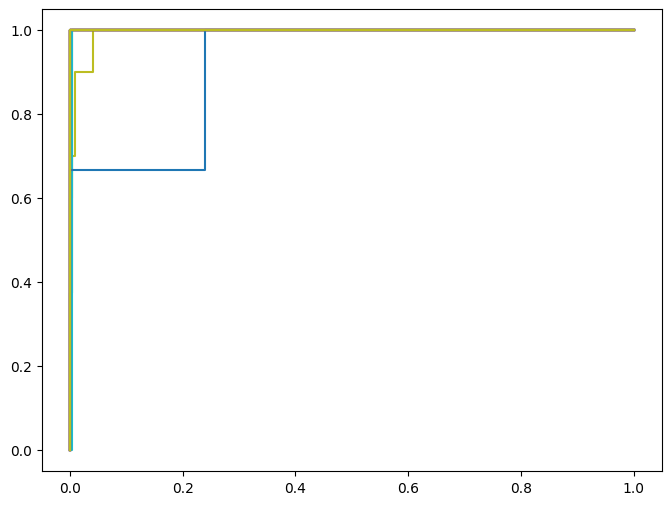

In [72]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

true_labels_bin = label_binarize(true_labels, classes=np.arange(len(label_encoder.classes_)))
fpr, tpr, thresholds = {}, {}, {}
roc_auc = {}

for i in range(len(label_encoder.classes_)):
    # Check if the class is present in the true labels
    if np.any(true_labels_bin[:, i]):
        fpr[i], tpr[i], thresholds[i] = roc_curve(true_labels_bin[:, i], raw_predictions.predictions[:, i])
        roc_auc[i] = roc_auc_score(true_labels_bin[:, i], raw_predictions.predictions[:, i])

plt.figure(figsize=(8, 6))
for i in range(len(label_encoder.classes_)):
    if i in roc_auc:  # if positive labels
        plt.plot(fpr[i], tpr[i], label=f'Class {label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})')

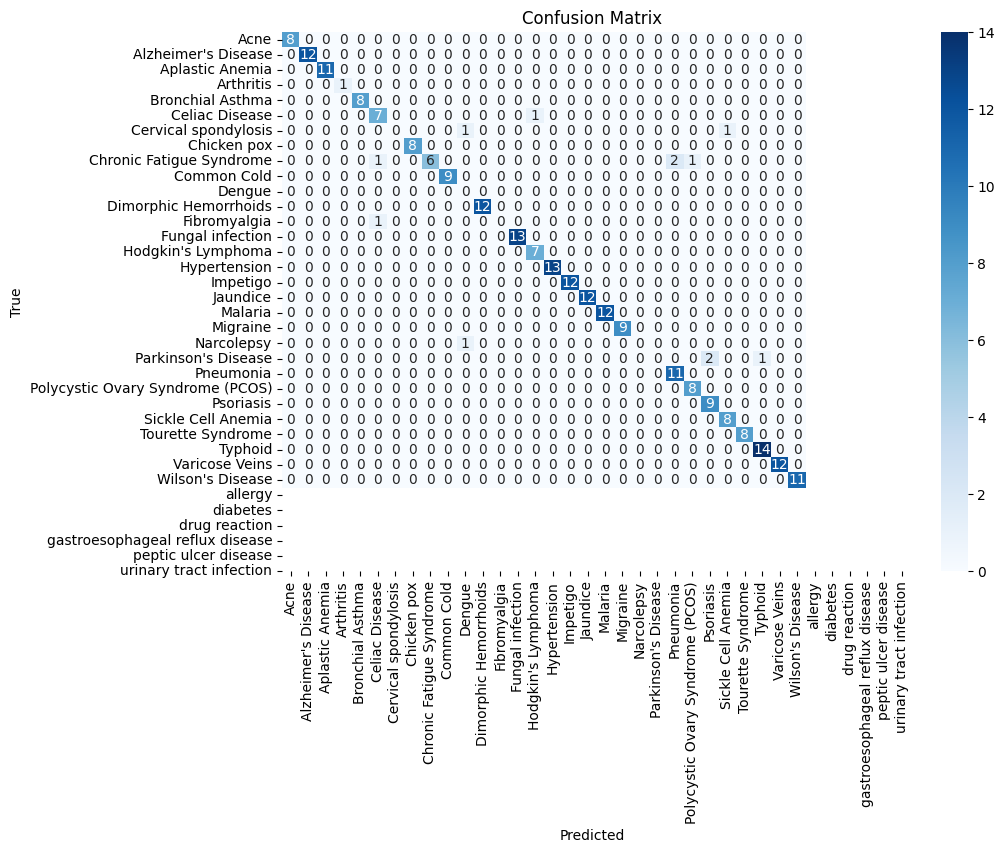

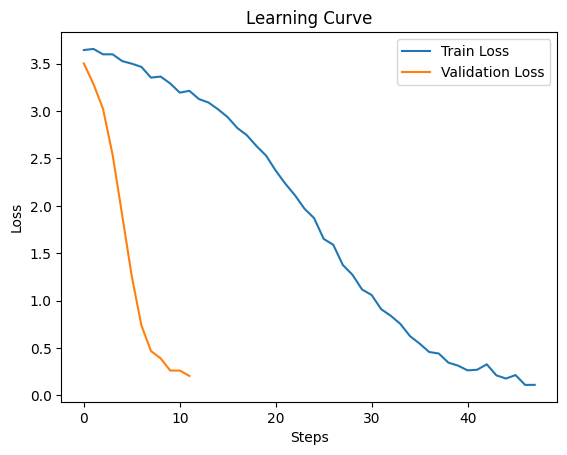

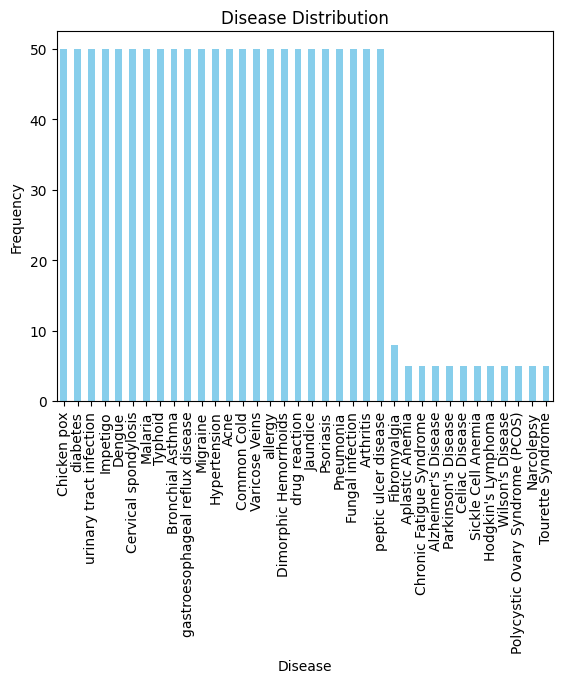

In [74]:
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

logs = trainer.state.log_history
train_loss = [log['loss'] for log in logs if 'loss' in log]
val_loss = [log['eval_loss'] for log in logs if 'eval_loss' in log]

plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.title("Learning Curve")
plt.show()

data['label'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Disease')
plt.ylabel('Frequency')
plt.title('Disease Distribution')
plt.xticks(rotation=90)
plt.show()
